# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns

#import libraries from pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, avg, desc, count, col
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler, StringIndexer,  StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")
#print schema for future reference
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
#Take a look at two rows as sample
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [7]:
#description of users
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [8]:
#amount of users the data is connected to
df.select('userId').dropDuplicates().count()

226

In [9]:
#description of sessions
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [10]:
#amount of sessions the data is connected to
df.select('sessionId').dropDuplicates().count()

2354

In [11]:
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [12]:
#display's top 20 rows containing userId's  
df_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [13]:
#display's top 20 rows containing sessionId's  
df_valid.select("sessionId").dropDuplicates().sort("userId").show()

+---------+
|sessionId|
+---------+
|     1338|
|       22|
|      330|
|      241|
|     2263|
|      155|
|      299|
|      237|
|      564|
|      347|
|       54|
|      926|
|      270|
|     1217|
|     2088|
|     1532|
|     1277|
|     1409|
|      656|
|      293|
+---------+
only showing top 20 rows



In [14]:
df_valid = df_valid.filter(df_valid['userId'] != "")

In [15]:
#amount of sessions the data is connected to
df_valid.count()

278154

In [16]:
#exploring the page feature
#Lets see what values page feature holds 
df_valid.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [17]:
df_valid.filter("page = 'Cancellation Confirmation'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|


In [18]:
#create a list for churn users
downgrade = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

#create a column for churn users
df_cancel = df_valid.withColumn("Churn", downgrade("page"))

In [19]:
#collects all rows having the selected information such as: userid, gender, level and ts.
df_cancel.select(['userId','gender','level','ts']).where(df_cancel.Churn == 1).sort('ts').collect()

[Row(userId='100011', gender='M', level='free', ts=1538417085000),
 Row(userId='100001', gender='F', level='free', ts=1538498205000),
 Row(userId='100024', gender='M', level='free', ts=1538695038000),
 Row(userId='300007', gender='M', level='paid', ts=1538705338000),
 Row(userId='100006', gender='F', level='free', ts=1538753070000),
 Row(userId='18', gender='M', level='paid', ts=1538943990000),
 Row(userId='100019', gender='M', level='free', ts=1538953071000),
 Row(userId='32', gender='M', level='paid', ts=1539033046000),
 Row(userId='100003', gender='F', level='free', ts=1539274781000),
 Row(userId='125', gender='M', level='free', ts=1539318918000),
 Row(userId='105', gender='M', level='paid', ts=1539375441000),
 Row(userId='17', gender='F', level='paid', ts=1539465584000),
 Row(userId='100023', gender='M', level='paid', ts=1539475237000),
 Row(userId='143', gender='F', level='free', ts=1539588854000),
 Row(userId='200001', gender='M', level='free', ts=1539629720000),
 Row(userId='101

In [20]:
# create a list for churn users
churn_user_df = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_user_list = [user["userId"] for user in churn_user_df.collect()]

In [21]:
# create a column for churn
valid = df_valid.withColumn("churn", df_valid.userId.isin(churn_user_list))

#### Differentiate the gender by two groups

In [22]:
# show gender difference in churn
valid.dropDuplicates(['userId']).groupby(['gender','churn']).count().show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M| true|   32|
|     F|false|   84|
|     F| true|   20|
|     M|false|   89|
+------+-----+-----+



In [23]:
#shows churn rate of user based on gender 
female_churn_rate = 20/(20+84)
male_churn_rate = 32/(32+89)
print("Churn rate of female is :",female_churn_rate)
print("Churn rate of male is :",male_churn_rate)

Churn rate of female is : 0.19230769230769232
Churn rate of male is : 0.2644628099173554


### Which were the songs played by two groups?

In [24]:
df_songs = valid.where(valid.song!='null').groupby(['churn','userId']).agg(count(valid.song).alias('SongsPlayed')).orderBy('churn').toPandas()

[]

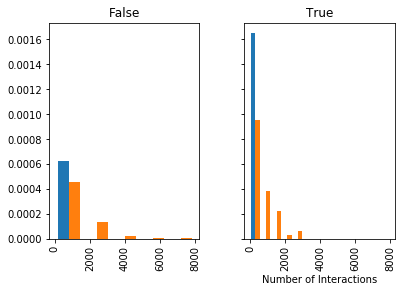

In [25]:
df_songs.hist(['SongsPlayed'], by='churn',bins =5, sharex=True, sharey=True, density = 1)
plt.xlabel('Number of Interactions')
plt.ylabel('frequency')
plt.plot()

### What are the Average numbers of thumbs-up and thumbs-down?

In [26]:
df_thumbsup = valid.where(valid.page=='Thumbs Up').groupby(['churn', 'userId'])\
.agg(count(col('page')).alias('Thumbs Up')).orderBy('churn').toPandas()

[]

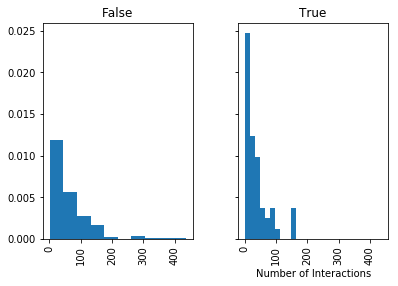

In [27]:
df_thumbsup.hist('Thumbs Up', by = 'churn', bins=10, sharex=True, sharey=True, density=1)
plt.xlabel('Number of Interactions')
plt.ylabel('frequency')
plt.plot()

In [28]:
df_thumbsdown = valid.where(valid.page=='Thumbs Down').groupby(['churn', 'userId'])\
.agg(count(col('page')).alias('Thumbs Down')).orderBy('churn').toPandas()

Text(0,0.5,'frequency')

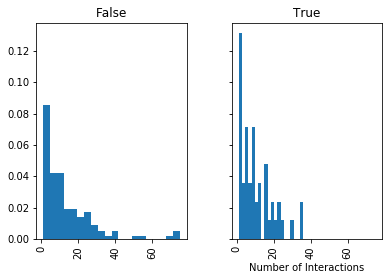

In [29]:
df_thumbsdown.hist('Thumbs Down', by = 'churn', bins=20, sharex=True, sharey=True, density=1)
plt.xlabel('Number of Interactions')
plt.ylabel('frequency')

### Which are the most played songs ?

In [30]:
#describes the feature artist
valid.describe('artist').show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [31]:
#Top 5 artists with most played songs along with the count  
valid.select(['page','artist']).where(valid.page=='NextSong').groupby(valid.artist).agg({'artist':'count'}).sort(desc('count(artist)')).show(5)

+--------------------+-------------+
|              artist|count(artist)|
+--------------------+-------------+
|       Kings Of Leon|         1841|
|            Coldplay|         1813|
|Florence + The Ma...|         1236|
|       Dwight Yoakam|         1135|
|            BjÃÂ¶rk|         1133|
+--------------------+-------------+
only showing top 5 rows



### To see the count of users that have subscribed for levels of their choice based on gender

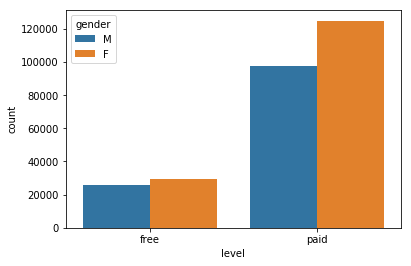

In [32]:
df1 = valid.groupby(['level','gender']).count().toPandas()

sns.barplot(x='level', y='count', hue='gender', data=df1)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Selection of necessary features

### 1. Gender feature

In [33]:
df_gender = valid.dropDuplicates(['userId']).sort('userId').select(['userId','gender'])
df_gender = df_gender.replace(['F','M'], ['1','0'], 'gender')
df_gender.withColumn('gender', df_gender.gender.cast('int'))

DataFrame[userId: string, gender: int]

In [34]:
df_gender.show()

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
|100004|     1|
|100005|     0|
|100006|     1|
|100007|     1|
|100008|     1|
|100009|     0|
|100010|     1|
|100011|     0|
|100012|     0|
|100013|     1|
|100014|     0|
|100015|     1|
|100016|     0|
|100017|     0|
|100018|     0|
+------+------+
only showing top 20 rows



## 2. Songs played

In [35]:
df_songs = valid.where(valid.song!='null').groupby('userId').agg(count(valid.song).alias('SongsPlayed')).orderBy('uderId').select(['userId','SongsPlayed'])

In [36]:
df_songs.show()

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
|100004|        942|
|100005|        154|
|100006|         26|
|100007|        423|
|100008|        772|
|100009|        518|
|100010|        275|
|100011|         11|
|100012|        476|
|100013|       1131|
|100014|        257|
|100015|        800|
|100016|        530|
|100017|         52|
|100018|       1002|
+------+-----------+
only showing top 20 rows



### 3. Thumbs  UP and DOWN

In [37]:
df_thumbsup = valid.where(valid.page=='Thumbs Up').groupby(['userId']).agg(count(col('page')).alias('ThumbsUps')).orderBy('userId').select(['userId','ThumbsUps'])

In [38]:
df_thumbsup = valid.where(valid.page=='Thumbs Down').groupby(['userId']).agg(count(col('page')).alias('ThumbsDowns')).orderBy('userId').select(['userId','ThumbsDowns'])


In [39]:
df_singers = valid.dropDuplicates(['userId','artist']).groupby('userId').agg(count(valid.artist).alias('SingersListened').orderBy('userId').select(['userId','SingersListened']))

In [40]:

df_singers.show()

+------+---------------+
|userId|SingersListened|
+------+---------------+
|    10|            565|
|   100|           1705|
|100001|            125|
|100002|            184|
|100003|             50|
|100004|            733|
|100005|            149|
|100006|             26|
|100007|            357|
|100008|            623|
|100009|            442|
|100010|            252|
|100011|             11|
|100012|            397|
|100013|            826|
|100014|            233|
|100015|            627|
|100016|            431|
|100017|             51|
|100018|            780|
+------+---------------+
only showing top 20 rows



In [41]:
final = valid.dropDuplicates(['userId']).sort('userId').select(['userId','churn'])
for feature in [df_gender, df_songs, df_thumbsup, df_thumbsdown, df_singers]:
    final = final.join(feature, 'userId')


In [42]:
final.show()

+------+-----+------+-----------+---------+-----------+---------------+
|userId|churn|gender|SongsPlayed|ThumbsUps|ThumbsDowns|SingersListened|
+------+-----+------+-----------+---------+-----------+---------------+
|100010|false|     1|        275|       17|          5|            252|
|200002|false|     0|        387|       21|          6|            339|
|   124|false|     1|       4079|      171|         41|           2232|
|    51| true|     0|       2111|      100|         21|           1385|
|     7|false|     0|        150|        7|          1|            142|
|    15|false|     0|       1914|       81|         14|           1302|
|    54| true|     1|       2841|      163|         29|           1744|
|   155|false|     1|        820|       58|          3|            643|
|100014| true|     0|        257|       17|          3|            233|
|   132|false|     1|       1928|       96|         17|           1299|
|   101| true|     0|       1797|       86|         16|         

In [43]:
final.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
| true|   47|
|false|  155|
+-----+-----+



In [44]:
# convert data type of columns into float
for feature in final.columns[1:]:
    final = final.withColumn(feature,final[feature].cast('float'))

In [45]:
final.show(5)

+------+-----+------+-----------+---------+-----------+---------------+
|userId|churn|gender|SongsPlayed|ThumbsUps|ThumbsDowns|SingersListened|
+------+-----+------+-----------+---------+-----------+---------------+
|100010|  0.0|   1.0|      275.0|     17.0|        5.0|          252.0|
|200002|  0.0|   0.0|      387.0|     21.0|        6.0|          339.0|
|   124|  0.0|   1.0|     4079.0|    171.0|       41.0|         2232.0|
|    51|  1.0|   0.0|     2111.0|    100.0|       21.0|         1385.0|
|     7|  0.0|   0.0|      150.0|      7.0|        1.0|          142.0|
+------+-----+------+-----------+---------+-----------+---------------+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Split full data into train and test

In [47]:
train, test = final.randomSplit([0.8,0.2], seed = 42)

In [48]:
assembler = VectorAssembler(inputCols = final.columns[2:], outputCol = 'featureassemble')
scaler = StandardScaler(inputCol = 'featureassemble',  outputCol = 'features', withStd = True)
indexer = StringIndexer(inputCol ='churn', outputCol = 'label')

lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

stringIndexer = StringIndexer(inputCol='label', outputCol='indexed')
rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol='indexed', seed=42)

## Build a pipeline for logistic regression model

In [49]:
pipeline_lr = Pipeline(stages=[assembler, scaler, indexer, lr])

paramGrid_lr = ParamGridBuilder().addGrid(lr.regParam,[0.0, 0.1, 0.01]).build()

crossval_lr = CrossValidation(estimator = pipeline_lr, estimatorParamMaps=paramGrid_lr, evaluator=BinaryClassificationEvaluator()
                              ,numFolds=3)


In [50]:
cv_lr = crossval_lr.fit(train)


In [51]:
cv_lr.avgMetrics

[0.6536680651198801, 0.6155775226488619, 0.6402190147496782]

In [52]:
# test performance
results = cv_lr.transform(test)
BinaryClassificationEvaluator().evaluate(results)

0.7238095238095238

#### It seems an inverse of an regularization strength as 0.01 yields the best validation performance.

In [54]:
#Change the random seed when splitting data int train and test.
train_2, test_2 = final.randomSplit([0.9,0.1], seed=43)
cv2_lr = crossval_lr.fit(train_2)
print(cv2_lr.avgMetrics)
res2 = cv_lr.transform(test_2)
print(BinaryClassificationEvaluator().evaluate(res2))


[0.6895920703497973, 0.6615385325504967, 0.6823895377359984]
0.392156862745098


In [55]:
#change the random seed again
train_3, test_3 = final.randomSplit([0.9, 0.1], seed=44)
cv3_lr = crossval_lr.fit(train_3)
print(cv3_lr.avgMetrics)
res3 = cv_lr.transform(test_3)
print(BinaryClassificationEvaluator().evaluate(res3))


[0.6439739514973709, 0.6213318492592499, 0.6342296039895574]
0.75


## Build a pipeline for Random Forest model

In [56]:
pipeline_rf = Pipeline(stages=[assembler, scaler, indexer, lr])

paramGrid_rf = ParamGridBuilder().addGrid(rf.numTrees,[10, 30]).build()

crossval_rf = CrossValidation(estimator = pipeline_rf, estimatorParamMaps=paramGrid_rf, evaluator=BinaryClassificationEvaluator()
                              ,numFolds=3)

## Compute F1 score for test data(RandomForest)

In [57]:
cv_rf = crossval_rf.fit(train)

In [58]:
cv_rf.avgMetrics

[0.6319258199733795, 0.6872190526758738]

In [59]:
res = cv_rf.transform(test)
print(BinaryClassificationEvaluator().evaluate(res))

0.7214285714285715


In [61]:
#change the random seed
train2, test2 = final.randomSplit([0.9, 0.1], seed = 43)
cv2_rf = crossval_rf.fit(train2)
print(cv2_rf.avgMetrics)
res2 = cv2_rf.transform(test2)
print(BinaryClassificationEvaluator().evaluate(res2))

[0.6493588348710483, 0.6597312229976737]
0.3137254901960784


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.